In [1]:
# import necessary packages

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

import psutil;

In [2]:
# Create a SparkContext instance
# Only run this code once, restart the kernel when in trouble
sc = SparkContext()
sc.setLogLevel("ERROR")

# Initialize a StreamingContext with 10 second batch interval. 
# Initialize a SQLContext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [3]:
# Connect with the TCP server on port 5555
socket_stream = ssc.socketTextStream("localhost", 5555)

lines = socket_stream.window(60) 

In [4]:
from collections import namedtuple

# Create a tuple / table to store the hashtags and their frequency
fields = ("hashtag", "count")
Tweet = namedtuple( 'Tweet', fields )

In [5]:
# Process incoming data into a temporary "tweets" table

( 
    # Split the incoming text into single words
    lines.flatMap( lambda text: text.split( " " ) )
    
    # Filter the words for hashtags
      .filter( lambda word: word.lower().startswith("#") )
    
    # Turn hashtags into lower case, so that "Corona" and "corona" are the same
      .map( lambda word: ( word.lower(), 1 ) )
    
    # When two keys are the same, reduce to one with the sum of the values
      .reduceByKey( lambda a, b: a + b ) 
    
    # Map the hashtags and their counts to Tweet objects
      .map( lambda rec: Tweet( rec[0], rec[1] ) )
    
    # Create DataFrames from the Tweet Objects, store top 10 into a "tweets" SQL table
      .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ).limit(10).registerTempTable("tweets")) 
)

In [6]:
# Start streaming, wait for enough tweets to come in
ssc.start()

In [7]:
# Visualize data

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline 

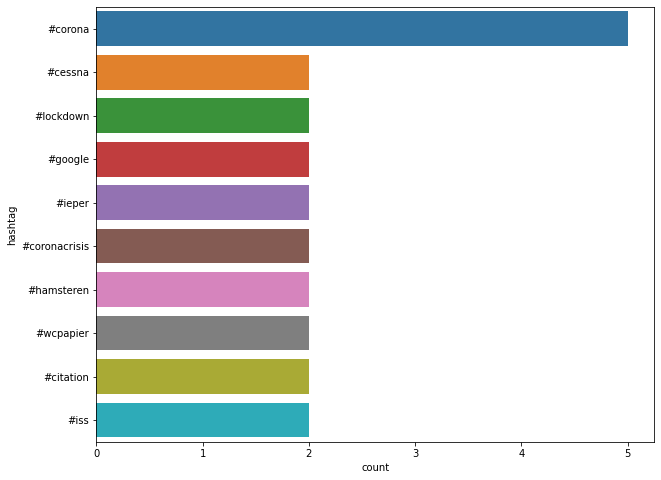

5


In [ ]:
count = 0
while count < 10:
    
    time.sleep(3)
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(count)

In [ ]:
ssc.stop()